# YOLOv11 for Drowsiness Detection

This notebook details the process of training a YOLO (You Only Look Once) classification model to detect driver drowsiness from images. The workflow covers every stage from environment setup and data acquisition to model training, in-depth evaluation with specialized metrics, and model explainability using Grad-CAM.

### 1. Setup Environment

We begin by setting up our Python environment. To ensure the project is organized and reproducible, we first define a `HOME` constant for our working directory. This makes all file paths relative and the notebook portable.

In [1]:
import os
HOME = os.getcwd()
print(f"Project Home Directory: {HOME}")

Project Home Directory: /workspace


Next, we install the necessary libraries.
- `ultralytics`: The core framework for our YOLO model.
- `kagglehub`: To easily download datasets from Kaggle.
- `grad-cam`: For model explainability.
- Other libraries like `numpy`, `opencv-python`, and `matplotlib` are standard tools for data manipulation and visualization.

In [2]:
%pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.3 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --no-cache-dir kagglehub==0.3.12 huggingface_hub==0.33.1 pillow numpy opencv-python==4.11.0.86 matplotlib==3.10.3 seaborn==0.13.2 pandas==2.3.0 scikit-learn==1.7.0 grad-cam==1.5.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 281.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 388.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 389.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 306.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 542.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 401.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 488.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 333.2 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=46c1d0cf0a4ca69b29ee924e248d1311559f62849bbcbb3d954fb526

In [4]:
%pip install --no-cache-dir ultralytics

import ultralytics
ultralytics.checks()

Ultralytics 8.3.160 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA RTX A5000, 24138MiB)
Setup complete ✅ (128 CPUs, 251.5 GB RAM, 0.5/20.0 GB disk)


In [8]:
import torch

DEVICE = "cpu"

print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current Device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
    DEVICE = torch.device("cuda")
print("Using DEVICE:", DEVICE)

CUDA available: True
Current Device: 0
Device name: NVIDIA RTX A5000
Using DEVICE: cuda


In [47]:
# Define the path to store all the dataset files
DOWNLOAD_PATH = os.path.join(HOME, "downloads")
DATASET_PATH = os.path.join(HOME, "dataset")
VISUALIZATION_PATH = os.path.join(HOME, "visualizations")

# Create the directories if they don't exist
os.makedirs(DOWNLOAD_PATH, exist_ok=True)
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(VISUALIZATION_PATH, exist_ok=True)

print(f"DOWNLOAD_PATH:{DOWNLOAD_PATH} \nDATASET_PATH:{DATASET_PATH} \nVISUALIZATION_PATH: {VISUALIZATION_PATH}")

DOWNLOAD_PATH:/workspace/downloads 
DATASET_PATH:/workspace/dataset 
VISUALIZATION_PATH: /workspace/visualizations


### 2. Download Dataset

We download two datasets. The primary dataset is used for training and validation, while a smaller, separate dataset is reserved for testing. Using a completely unseen test set provides a more realistic measure of the model's generalization performance.

**Datasets:**
*   [Driver Drowsiness Dataset (DDD)](https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd) (41,790 images)
*   [Driver Drowsiness Detection](https://universe.roboflow.com/tesi-jotog/driver-drowsiness-detection-7fvkf) (7,342 images)

In [7]:
import os
# Set environment variable before importing or using kagglehub
os.environ['KAGGLEHUB_CACHE'] = DOWNLOAD_PATH

import kagglehub

# Download the datasets from Kaggle
download_paths = [] 
dataset_urls = [
    'ismailnasri20/driver-drowsiness-dataset-ddd',
    'yasharjebraeily/drowsy-detection-dataset'
]

for url in dataset_urls:
    download_path = kagglehub.dataset_download(url)
    download_paths.append(download_path)
    
print(f'kaggle Datasets downloaded to: {download_paths}')

100%|██████████| 2.58G/2.58G [00:16<00:00, 173MB/s] 

Extracting files...


100%|██████████| 14.2M/14.2M [00:00<00:00, 73.6MB/s]

Extracting files...


kaggle Datasets downloaded to: ['/workspace/downloads/datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1', '/workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1']


Verify the structure of the downloaded files

In [8]:
for root, dirs, files in os.walk(DOWNLOAD_PATH):
    print(f'Found folder: {root} with {len(files)} files')

Found folder: /workspace/downloads with 0 files
Found folder: /workspace/downloads/datasets with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset with 1 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1 with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train/NATURAL with 3050 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train/

### 3. Organize Dataset

The `ultralytics` YOLO trainer expects a specific directory structure for classification tasks. We need to organize our downloaded images into `train`, `val` (validation), and `test` folders. Within each of these, we need subfolders named after our classes (e.g., `Drowsy`, `Non Drowsy`).

**Required Structure:**
```
dataset/
├── train/
│   ├── Drowsy/
│   └── Non Drowsy/
├── val/
│   ├── Drowsy/
│   └── Non Drowsy/
└── test/
    ├── Drowsy/
    └── Non Drowsy/
```

We Organize the dataset by doing these:
1.   Split the first dataset into train and val set (while keeping their labels intact).
2.   Merge the second dataset into a single test set (while keeping their labels intact)

In [9]:
# Organizes downloaded datasets into clean train/val/test structure, respecting original splits
import os
import shutil
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

def setup_directories(base_path, splits=['train', 'val', 'test'], classes=['Drowsy', 'Non Drowsy']):
    """Create clean directory structure"""
    base = Path(base_path)
    if base.exists():
        shutil.rmtree(base)
        print(f"Removed existing directory: {base}")
    
    for split in splits:
        for cls in classes:
            (base / split / cls).mkdir(parents=True, exist_ok=True)
    print("Created fresh train/val/test directories.")
    return {split: base / split for split in splits}

def process_yashar_dataset(download_path, dirs):
    """Process yasharjebraeily dataset - move test data, collect trainable files"""
    yashar_path = Path(download_path) / 'datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset'
    class_map = {'DROWSY': 'Drowsy', 'NATURAL': 'Non Drowsy'}
    trainable_files = []
    
    if not yashar_path.exists():
        print("Warning: 'yasharjebraeily' path not found.")
        return trainable_files
    
    print("Processing 'yasharjebraeily' dataset...")
    
    # Move test files and collect train files
    for split in ['test', 'train']:
        for src_class, dst_class in class_map.items():
            src_dir = yashar_path / split / src_class
            if not src_dir.exists():
                continue
                
            files = list(src_dir.glob('*.*'))
            if split == 'test':
                for i, f in enumerate(tqdm(files, desc=f'Moving yashar test/{src_class}')):
                    # Add unique prefix to test files to avoid collisions
                    new_name = f"yashar_test_{f.stem}_{i:04d}{f.suffix}"
                    shutil.move(str(f), dirs['test'] / dst_class / new_name)
            else:
                trainable_files.extend([(f, dst_class) for f in files])
    
    print(f"Finished 'yasharjebraeily'. Collected {len(trainable_files)} trainable files.")
    return trainable_files

def process_ismail_dataset(download_path, classes):
    """Process ismailnasri20 dataset - collect all files for training"""
    ismail_path = Path(download_path) / 'datasets/ismailnasri20/driver-drowsiness-dataset-ddd/versions/1/Driver Drowsiness Dataset (DDD)'
    trainable_files = []
    
    if not ismail_path.exists():
        print("Warning: 'ismailnasri20' path not found.")
        return trainable_files
    
    print("Processing 'ismailnasri20' dataset...")
    for class_name in classes:
        src_dir = ismail_path / class_name
        if src_dir.exists():
            trainable_files.extend([(f, class_name) for f in src_dir.glob('*.*')])
    
    print(f"Finished 'ismailnasri20'. Collected {len(trainable_files)} trainable files.")
    return trainable_files

def create_train_val_split(trainable_files, dirs):
    """Split trainable files into train/val sets and move them"""
    if not trainable_files:
        print("No trainable files found to create train/val splits.")
        return
    
    print("Creating train/validation split...")
    filepaths, labels = zip(*trainable_files)
    
    train_files, val_files, train_labels, val_labels = train_test_split(
        filepaths, labels, test_size=0.15, random_state=42, stratify=labels
    )
    
    # Move files to destinations with unique naming
    for files, labels, split_dir in [(train_files, train_labels, 'train'), (val_files, val_labels, 'val')]:
        for i, (f, label) in enumerate(tqdm(zip(files, labels), desc=f'Moving files to {split_dir} set', total=len(files))):
            # Normalize label names
            dest_label = 'Drowsy' if label in ['DROWSY', 'Drowsy'] else 'Non Drowsy'
            # Create unique filename to avoid collisions
            file_path = Path(f)
            dataset_prefix = 'yashar_' if 'yasharjebraeily' in str(f) else 'ismail_'
            new_name = f"{dataset_prefix}{file_path.stem}_{i:04d}{file_path.suffix}"
            shutil.move(str(f), dirs[split_dir] / dest_label / new_name)

def print_summary(dirs):
    """Print final dataset statistics"""
    print("\n--- Dataset Organization Complete ---")
    for split_name, split_dir in dirs.items():
        drowsy_count = len(list((split_dir / 'Drowsy').iterdir()))
        nondrowsy_count = len(list((split_dir / 'Non Drowsy').iterdir()))
        print(f"{split_name.title()} Set: {drowsy_count} Drowsy | {nondrowsy_count} Non Drowsy")

# Main execution
print("--- Starting Dataset Organization ---")

# Setup
dirs = setup_directories(DATASET_PATH)
class_names = ['Drowsy', 'Non Drowsy']

# Process datasets and collect trainable files
yashar_files = process_yashar_dataset(DOWNLOAD_PATH, dirs)
ismail_files = process_ismail_dataset(DOWNLOAD_PATH, class_names)

# Create final splits
all_trainable = yashar_files + ismail_files
create_train_val_split(all_trainable, dirs)

# Summary
print_summary(dirs)

--- Starting Dataset Organization ---
Removed existing directory: /workspace/dataset
Created fresh train/val/test directories.
Processing 'yasharjebraeily' dataset...


Moving yashar test/DROWSY:   0%|          | 0/757 [00:00<?, ?it/s]

Moving yashar test/NATURAL:   0%|          | 0/726 [00:00<?, ?it/s]

Finished 'yasharjebraeily'. Collected 5859 trainable files.
Processing 'ismailnasri20' dataset...
Finished 'ismailnasri20'. Collected 41793 trainable files.
Creating train/validation split...


Moving files to train set:   0%|          | 0/40504 [00:00<?, ?it/s]

Moving files to val set:   0%|          | 0/7148 [00:00<?, ?it/s]


--- Dataset Organization Complete ---
Train Set: 21383 Drowsy | 19121 Non Drowsy
Val Set: 3774 Drowsy | 3374 Non Drowsy
Test Set: 757 Drowsy | 726 Non Drowsy


### 4. Clean Dataset

Before training, it is crucial to scan our dataset for problematic images. Corrupted files, oversized images, or low-quality images (e.g., solid black) can destabilize training and degrade model performance. This data cleaning step acts as a quality gate, ensuring our model learns from clean, valid data.

The script below uses multiprocessing to efficiently check every image for:
- Zero-byte or oversized files.
- Extreme dimensions (too large or too small).
- Low variance (e.g., solid color images).
- Corrupted image headers.

In [10]:
import os
from PIL import Image, UnidentifiedImageError
import numpy as np
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm
from pathlib import Path

# --- Configuration Constants ---
dry_run = True                         # Set to False to enable deletion
problem_images_log_file = "problematic_images.log"   # Log file name
num_workers = cpu_count()             # Adjust manually if needed
max_file_size_mb = 250  * 1024 * 1024 # 250mb
max_image_pixels = 178956970
min_width = 32
min_height = 32
low_variance_threshold = 10
supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')

def verify_image(file_path, delete_on_error=False):
    """Verify image against security and quality criteria."""
    try:
        file_size = os.path.getsize(file_path)
        if file_size == 0:
            return handle_problem(file_path, "File is zero bytes.", delete_on_error)

        if file_size > max_file_size_mb:
            return handle_problem(file_path, 
                f"File size ({file_size/1024**2:.1f}MB) exceeds limit ({max_file_size_mb/1024**2:.1f}MB).", 
                delete_on_error)

        with Image.open(file_path) as img:
            pixels = img.width * img.height

            if pixels > max_image_pixels:
                return handle_problem(file_path,
                    f"Dimensions ({img.width}x{img.height}={pixels/1e6:.1f}MP) exceed limit ({max_image_pixels/1e6:.1f}MP).",
                    delete_on_error)

            if img.width < min_width or img.height < min_height:
                return handle_problem(file_path,
                    f"Dimensions ({img.width}x{img.height}) below minimum ({min_width}x{min_height}).",
                    delete_on_error)

            img.load()
            img_array = np.array(img.convert('RGB'))
            if img_array.std() < low_variance_threshold:
                return handle_problem(file_path,
                    f"Low variance ({img_array.std():.1f}) - likely solid color.",
                    delete_on_error)

        return 'OK', file_path, "Verified successfully."

    except UnidentifiedImageError:
        return handle_problem(file_path, "Cannot identify image file - corrupted or invalid.", delete_on_error)
    except (IOError, OSError) as e:
        return handle_problem(file_path, f"IO/OS Error: {e}", delete_on_error)
    except Exception as e:
        return handle_problem(file_path, f"Unexpected error: {e}", delete_on_error)

def handle_problem(file_path, reason, delete_on_error):
    if delete_on_error:
        try:
            os.remove(file_path)
            return 'DELETED', file_path, reason
        except OSError as e:
            return 'PROBLEM', file_path, f"{reason} | Could not delete: {e}"
    return 'PROBLEM', file_path, reason

def get_image_files(root_dir):
    image_paths = [str(p) for p in Path(root_dir).rglob('*') if p.suffix.lower() in supported_extensions]
    print(f"Found {len(image_paths)} image files in '{root_dir}'")
    return image_paths


image_files = get_image_files(DATASET_PATH)
verify_func = partial(verify_image, delete_on_error=not dry_run)
problems = []
print(f"{'DRY-RUN MODE' if dry_run else 'DELETE MODE'}: Starting verification with {min(num_workers, len(image_files))} workers...")

with Pool(min(num_workers, len(image_files))) as pool, open(problem_images_log_file, 'w') as log_f:
    log_f.write(f"Dataset: {DATASET_PATH} | Mode: {'DRY-RUN' if dry_run else 'DELETE'}\n{'-'*50}\n")
    for result in tqdm(pool.imap_unordered(verify_func, image_files), 
                        total=len(image_files), desc="Verifying", unit="img"):
        if result[0] != 'OK':
            problems.append(result)
            log_f.write(f"[{result[0]}] {result[1]}: {result[2]}\n")

# Summary
ok_count = len(image_files) - len(problems)
deleted_count = sum(1 for r in problems if r[0] == 'DELETED')

print(f"\n--- Summary ---")
print(f"Total: {len(image_files)} | OK: {ok_count} | {'Problems' if dry_run else 'Deleted'}: {len(problems) if dry_run else deleted_count}")
print(f"Details logged to: {problem_images_log_file}")

Found 49135 image files in '/workspace/dataset'
DRY-RUN MODE: Starting verification with 128 workers...


Verifying: 100%|██████████| 49135/49135 [00:18<00:00, 2640.83img/s]



--- Summary ---
Total: 49135 | OK: 49125 | Problems: 10
Details logged to: problematic_images.log


All the datasets have now been organized.

In [11]:
for root, dirs, files in os.walk(DOWNLOAD_PATH):
    print(f'Found folder: {root} with {len(files)} files')

Found folder: /workspace/downloads with 0 files
Found folder: /workspace/downloads/datasets with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset with 1 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1 with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train/NATURAL with 0 files
Found folder: /workspace/downloads/datasets/yasharjebraeily/drowsy-detection-dataset/versions/1/Drowsy_datset/train/DRO

In [12]:
# Count the total number of images in the dataset

for root, dirs, files in os.walk(DATASET_PATH):
    print(f'Found folder: {root} with {len(files)} files')
    
for root, dirs, files in os.walk(DATASET_PATH):
    print(f"Total {str(os.path.basename(root)).upper()} images : {len(files)}")

Found folder: /workspace/dataset with 0 files
Found folder: /workspace/dataset/test with 0 files
Found folder: /workspace/dataset/test/Non Drowsy with 726 files
Found folder: /workspace/dataset/test/Drowsy with 757 files
Found folder: /workspace/dataset/val with 0 files
Found folder: /workspace/dataset/val/Non Drowsy with 3374 files
Found folder: /workspace/dataset/val/Drowsy with 3774 files
Found folder: /workspace/dataset/train with 0 files
Found folder: /workspace/dataset/train/Non Drowsy with 19121 files
Found folder: /workspace/dataset/train/Drowsy with 21383 files
Total DATASET images : 0
Total TEST images : 0
Total NON DROWSY images : 726
Total DROWSY images : 757
Total VAL images : 0
Total NON DROWSY images : 3374
Total DROWSY images : 3774
Total TRAIN images : 0
Total NON DROWSY images : 19121
Total DROWSY images : 21383


#### Exploratory Data Analysis (EDA)
ask.
After cleaning, we perform a quick visual check of our dataset. Displaying a random grid of images helps us confirm that the classes are correct, the images are of reasonable quality, and our data loading process is working as expected.

In [13]:
import os
import math
import random

import cv2
import matplotlib.pyplot as plt

# Randomly selects images from dataset, creates a grid image, and saves it.
filepaths = []
dataset_grid_image = ""
no_of_images=20

# Use os.walk to find all image files in DATASET_PATH and subdirectories
for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepaths.append(os.path.join(root, file))
            
if filepaths:
    num_to_sample = min(no_of_images, len(filepaths))
    images_to_visualize = random.sample(filepaths, num_to_sample)
    images = []
    for image_path in images_to_visualize:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not read image at {image_path}. Skipping.")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        title = f"{os.path.basename(os.path.dirname(image_path))}/{os.path.basename(image_path)}"
        images.append((image, title))

    
    if images:    
        # Determine grid size (e.g., for 5 images: 3x2 grid)
        grid_cols = math.ceil(math.sqrt(len(images)))
        grid_rows = math.ceil(len(images) / grid_cols)
        fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
        axs = axs.flatten()
        for ax, (img, title) in zip(axs, images):
            ax.imshow(img)
            ax.set_title(title, fontsize=10)
            ax.axis("off")
        # Hide any unused subplots
        for ax in axs[len(images):]:
            ax.axis("off")
        plt.tight_layout()
        dataset_grid_image = os.path.join(VISUALIZATION_PATH, f'dataset_visualization_grid.png')
        plt.savefig(dataset_grid_image)
        plt.close(fig)
        print(dataset_grid_image) # it is an image path string

/workspace/visualizations/dataset_visualization_grid.png


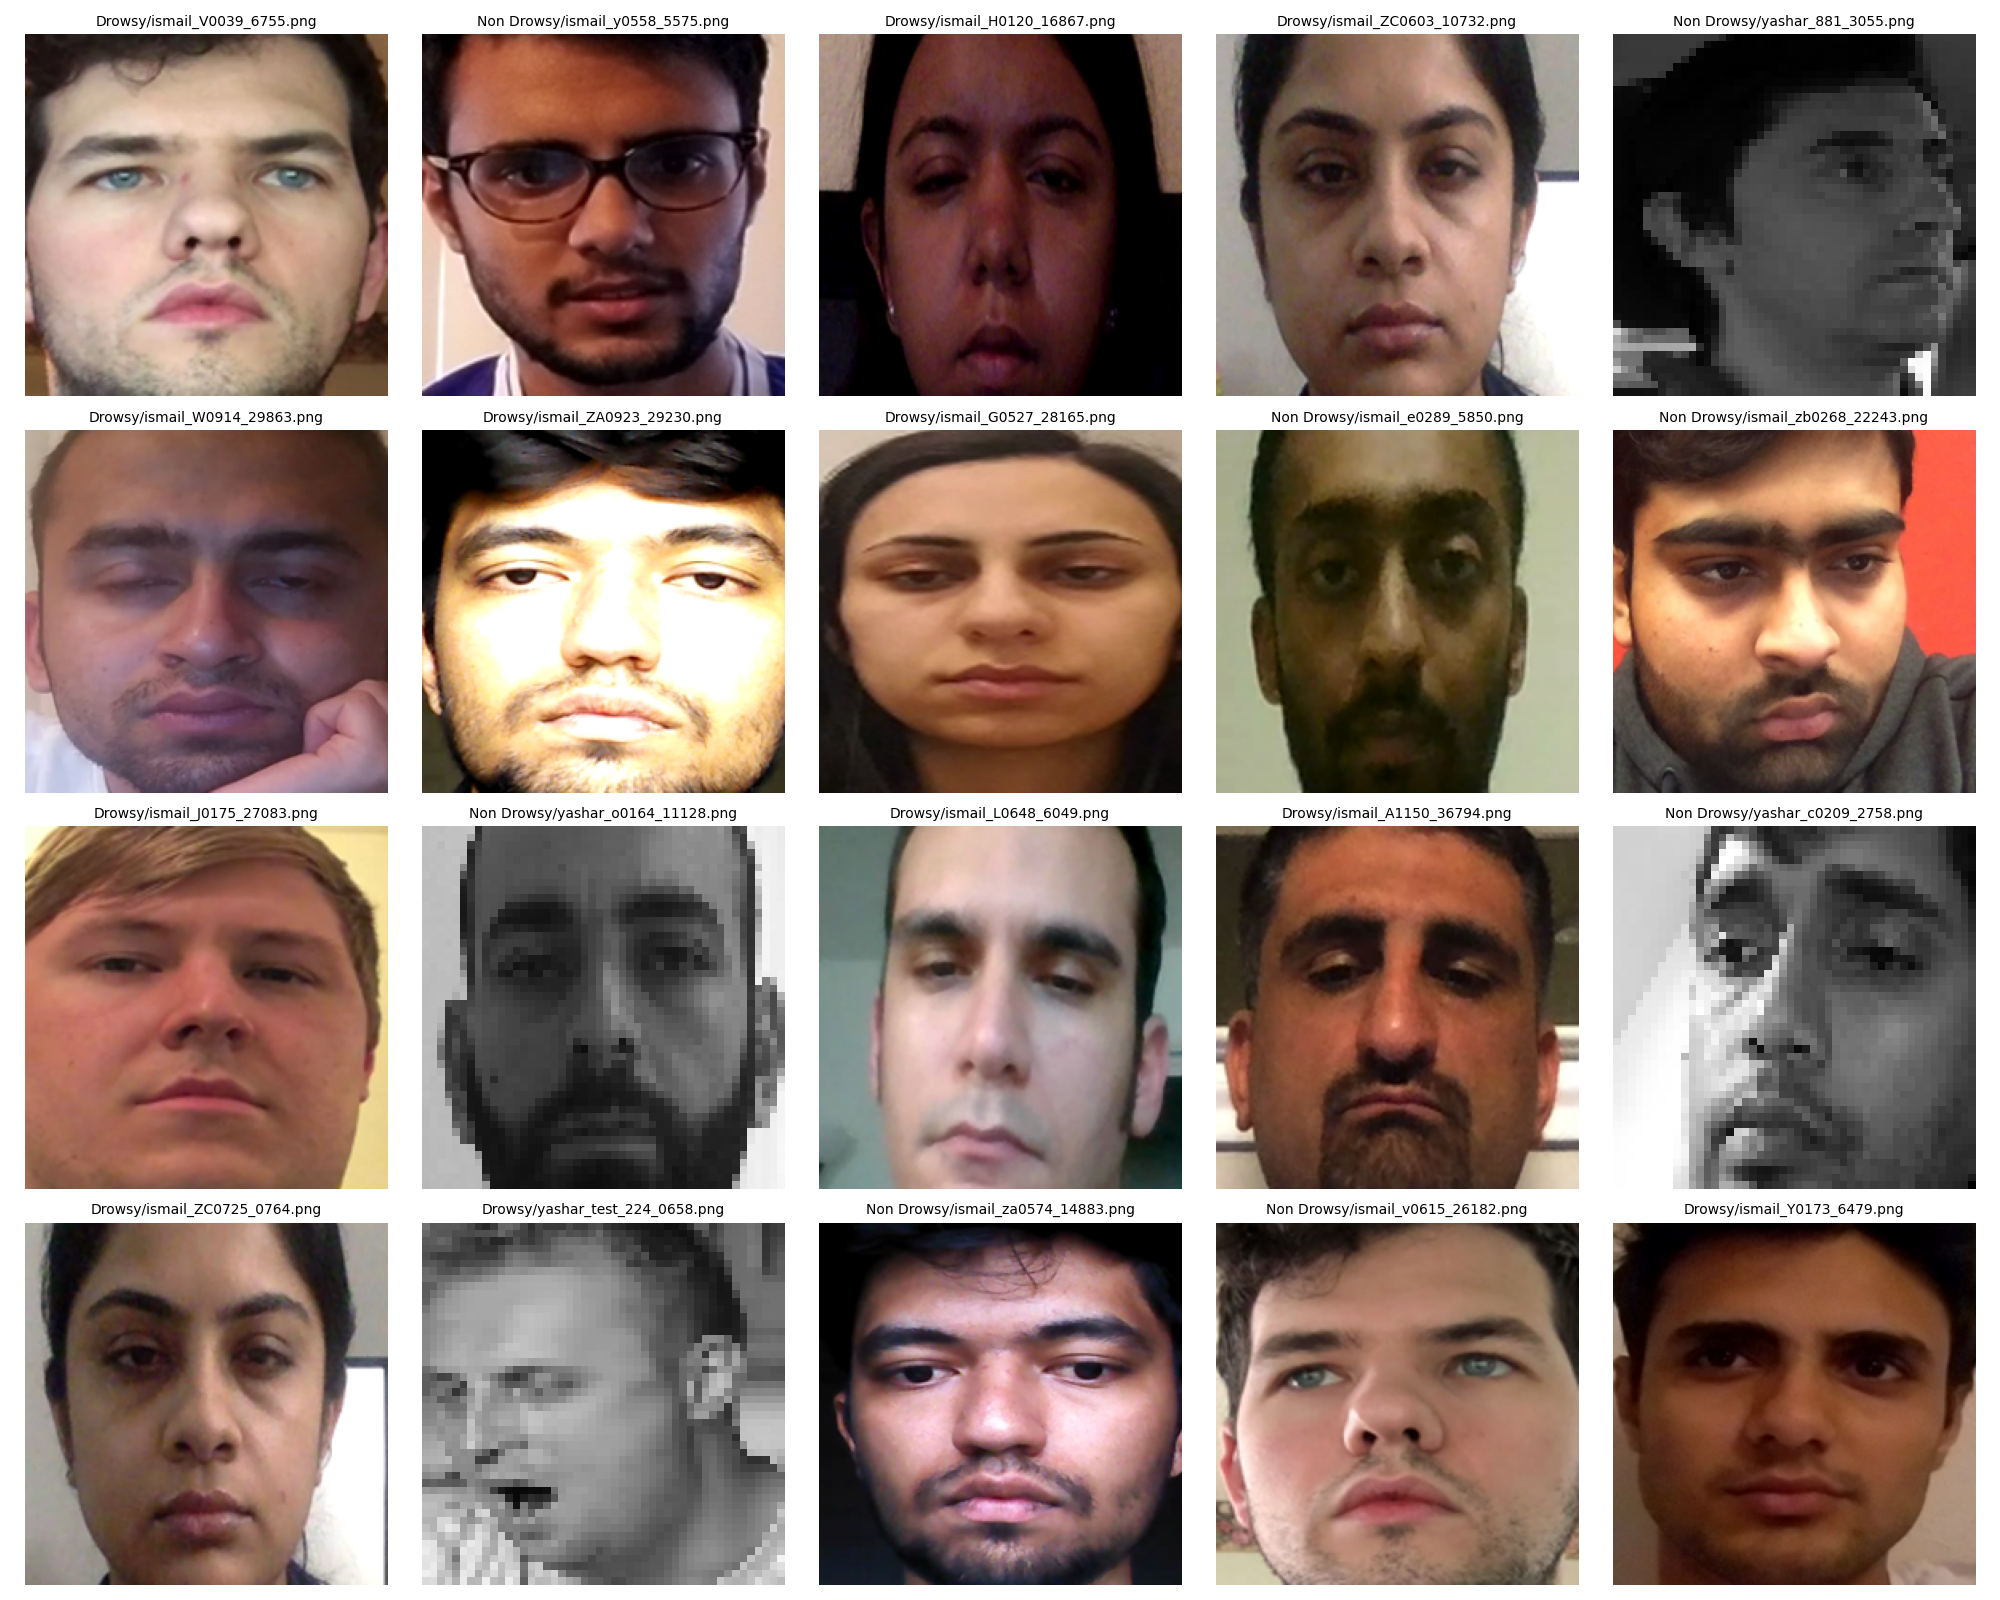

In [14]:
from IPython.display import Image as IPyImage

# Display the image
IPyImage(filename=dataset_grid_image, width=600)

#### Augmentation Visualization

Before we start training, it's crucial to understand what our model will actually be "seeing". The `ultralytics` trainer applies a variety of random data augmentations to the training images in each epoch. These transformations—such as color shifts (Hue, Saturation, Value), rotations, scaling, and flipping—create a more diverse training set, which is a powerful technique to help the model generalize better and prevent overfitting.

In this step, we will visualize these augmentations. We'll take a sample image from our training set and repeatedly apply the transformation pipeline to them, displaying the results in a grid. This allows us to visually inspect the severity and variety of the augmentations and ensure they are appropriate for our task.

Visualizing: Fast image access ✅ (ping: 0.2±0.1 ms, read: 87.8±26.0 MB/s, size: 63.3 KB)


Visualizing: Scanning /workspace/dataset/train... 40504 images, 0 corrupt: 100%|██████████| 40504/40504 [00:00<?, ?it/s]


Visualizing augmentations for 3 images...


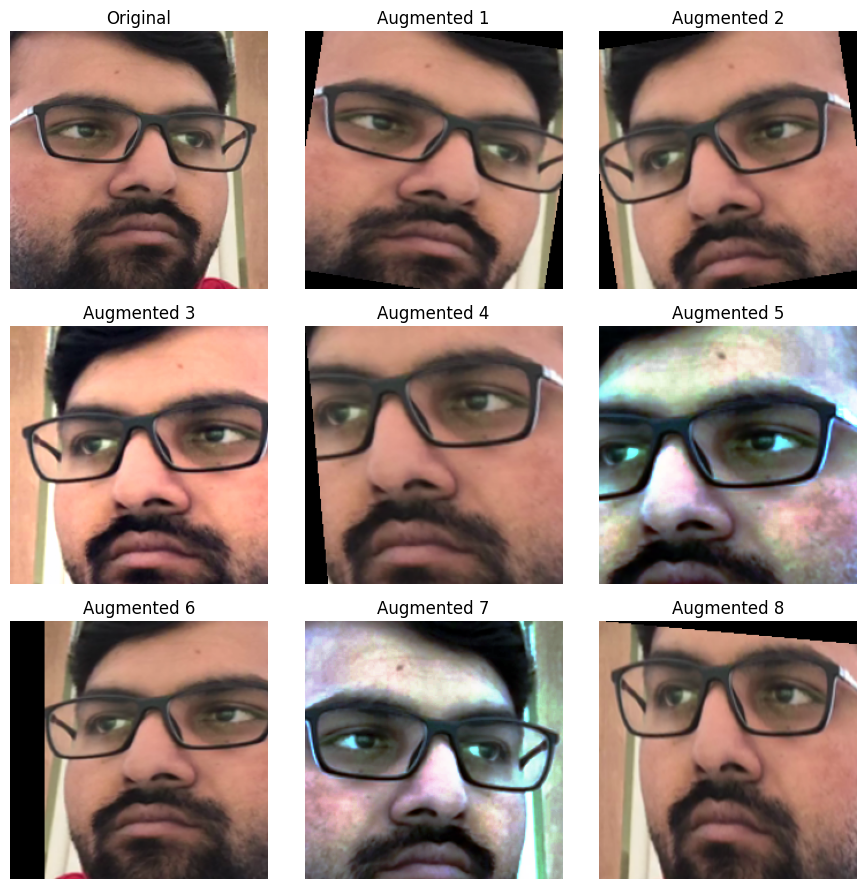

Saved augmentation grid to: /workspace/visualizations/augmentation_grid_0.png


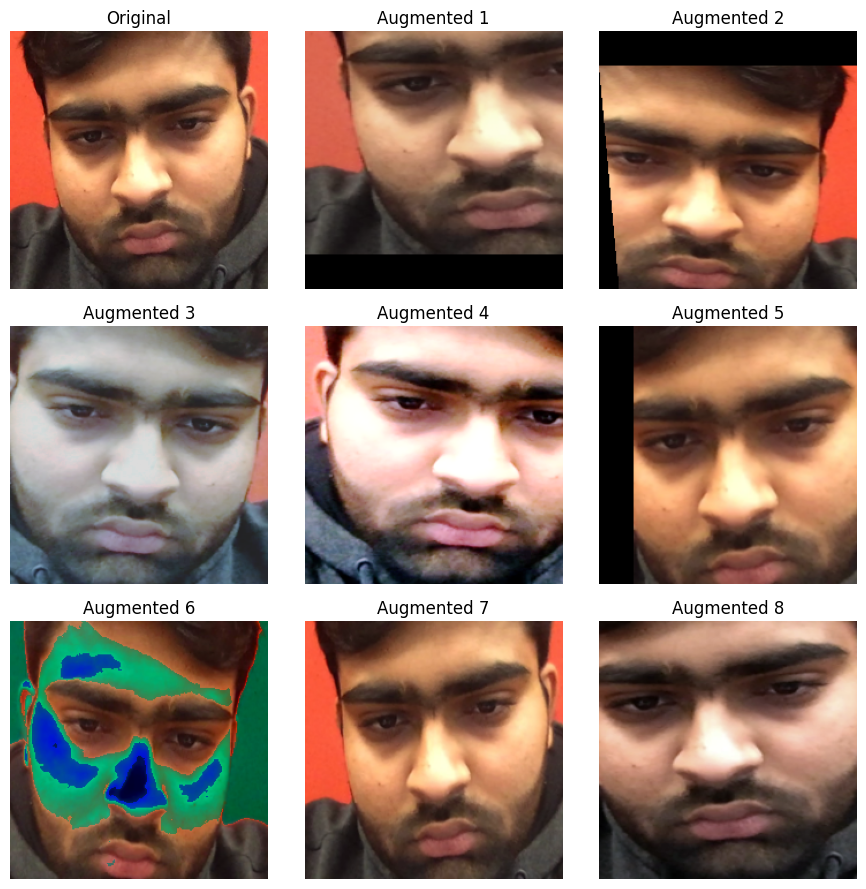

Saved augmentation grid to: /workspace/visualizations/augmentation_grid_1.png


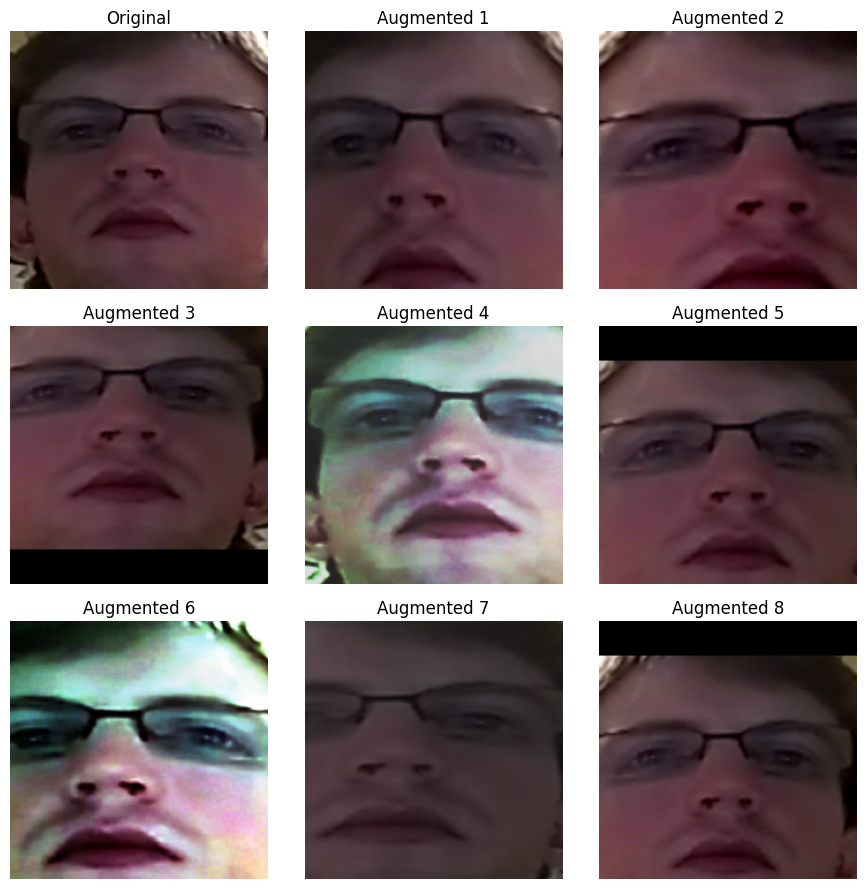

Saved augmentation grid to: /workspace/visualizations/augmentation_grid_2.png


In [19]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics.data.dataset import ClassificationDataset
from types import SimpleNamespace

# --- Configuration ---
num_images_to_show = 3       # How many different original images to visualize
augmentations_per_image = 8  # How many augmented versions to show for each original
image_size = 224             # The image size used during training

# --- Create a mock 'args' object to configure the dataset ---
# The ClassificationDataset expects an object with attributes for configuration.
# We mimic the structure used internally by ultralytics.
args = SimpleNamespace(
    imgsz=image_size,
    cache=False,        # Disable caching for this visualization
    fraction=1.0,       # Use the full dataset
    scale=0.5,          # Default scale for augmentation
    fliplr=0.5,         # Horizontal flip probability
    flipud=0.0,         # Vertical flip probability
    erasing=0.0,        # Random erasing probability
    auto_augment='randaugment', # Type of auto-augmentation
    hsv_h=0.015,        # Hue augmentation
    hsv_s=0.7,          # Saturation augmentation
    hsv_v=0.4           # Value augmentation
)


# --- Dataset Loading ---
train_images_path = os.path.join(DATASET_PATH, 'train')

# Instantiate the dataset with augmentations enabled, passing the args object
augmented_dataset = ClassificationDataset(root=train_images_path, args=args, augment=True, prefix="Visualizing")

# Get a list of all image file paths
# Note: The 'samples' attribute holds tuples of (filepath, class_index)
all_image_samples = augmented_dataset.samples

if not all_image_samples:
    print("No training images found. Please ensure the dataset is organized correctly.")
else:
    # Randomly sample some image indices to visualize
    sample_indices = random.sample(range(len(all_image_samples)), min(num_images_to_show, len(all_image_samples)))
    
    print(f"Visualizing augmentations for {len(sample_indices)} images...")

    for i, image_idx in enumerate(sample_indices):
        # --- Create a plot grid ---
        # Grid size will be one larger than augmentations_per_image to show the original
        grid_size = int(np.ceil(np.sqrt(augmentations_per_image + 1)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 3, grid_size * 3))
        axes = axes.flatten()

        # --- 1. Display the Original Image ---
        original_path, _ = all_image_samples[image_idx][:2] # Get filepath from sample tuple
        original_image = cv2.imread(original_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        axes[0].imshow(original_image)
        axes[0].set_title("Original")
        axes[0].axis("off")

        # --- 2. Display Augmented Versions ---
        for j in range(augmentations_per_image):
            # Get an augmented image by accessing the dataset
            # Each access triggers a new random transformation
            augmented_data = augmented_dataset[image_idx]
            augmented_tensor = augmented_data['img']

            # Denormalize: Convert tensor back to a displayable image
            # The dataset returns a CHW tensor with values in [0, 1]. We need HWC numpy array.
            img_np = augmented_tensor.permute(1, 2, 0).cpu().numpy()
            img_np = np.clip(img_np, 0, 1) # Ensure values are in the valid range for display
            
            ax = axes[j + 1]
            ax.imshow(img_np)
            ax.set_title(f"Augmented {j+1}")
            ax.axis("off")

        # Hide any unused subplots
        for k in range(augmentations_per_image + 1, len(axes)):
            axes[k].axis("off")

        plt.tight_layout()
        
        # Save the visualization
        output_path = os.path.join(VISUALIZATION_PATH, f'augmentation_grid_{i}.png')
        plt.savefig(output_path)
        plt.show()
        print(f"Saved augmentation grid to: {output_path}")

### 5. Model Training

The `ultralytics` library provides a `.train()` method that handles the entire training loop, including data augmentation, optimization, and validation. 

**Key Training Parameters:**
- `data`: Path to the root dataset directory.
- `epochs`: The number of times to iterate over the entire training dataset.
- `patience`: A crucial parameter for **early stopping**. It halts training if the validation metric doesn't improve for a specified number of epochs, preventing overfitting and saving computational resources.
- `batch`: The number of images to process in one go. This should be adjusted based on available GPU memory.
- `device`: Specifies whether to use a 'cuda' GPU or 'cpu'.

Load the Model

In [6]:
from ultralytics import YOLO

model = YOLO("yolo11x-cls")

print(f"Model: {str(model)[:300]} \nClass: {type(model)} \nTrainable parameters : {sum(p.numel() for p in model.parameters() if p.requires_grad)} \nLayer weights: {list(model.state_dict().keys())}")

100%|██████████| 56.9M/56.9M [00:00<00:00, 130MB/s]


Model: YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True) 
Class: <class 'ultralytics.models.yolo.model.YOLO'> 
Trainable parameters : 0 
Layer weights: ['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2

Train the model

In [9]:
# Train the YOLO classification model
results = model.train(
    data=DATASET_PATH, 
    epochs=300, 
    imgsz=224, 
    batch=-1,  # -1 means Ultralytics automatically finds the best batch size. 
    patience=20, # Enable early stopping
    project='drowsiness_training', 
    name='yolo_cls_run', 
    save=True,
    device=DEVICE, 
    cache=True, # Cache images for faster loading
    plots=True, # Generate and save training plots
    exist_ok=True # Overwrite previous run with the same name
)

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/workspace/dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_cls_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=drowsiness_training, rect=False, resume=False, retina_

100%|██████████| 5.35M/5.35M [00:00<00:00, 82.4MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=224 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA RTX A5000) 23.57G total, 0.42G reserved, 0.26G allocated, 22.90G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    28358626        13.6         0.889          32.6         310.5        (1, 3, 224, 224)                  (1, 2)
    28358626       27.19         1.168         20.67         121.3        (2, 3, 224, 224)                  (2, 2)
    28358626       54.38         1.453         21.57         130.6        (4, 3, 224, 224)                  (4, 2)
    28358626       108.8         1.701         23.05         110.9        (8, 3, 224, 224)                  (8, 2)
    28358626       217.5         2.240         26.08         112.2       (16, 3, 224, 224)                 (16, 2)
    28358626       435.1         3.295         31.71         111.9       (32, 3, 224, 224)               

train: Scanning /workspace/dataset/train... 40504 images, 0 corrupt: 100%|██████████| 40504/40504 [00:00<?, ?it/s]


WARNING ⚠️ Classification `cache_ram` training has known memory leak in https://github.com/ultralytics/ultralytics/issues/9824, setting `cache_ram=False`.
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 32.1±3.7 MB/s, size: 63.3 KB)


val: Scanning /workspace/dataset/val... 7148 images, 0 corrupt: 100%|██████████| 7148/7148 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 82 weight(decay=0.0), 83 weight(decay=0.0014453125), 83 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to drowsiness_training/yolo_cls_run
Starting training for 300 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/300        14G      0.741        185        224:   1%|          | 2/219 [00:01<02:47,  1.30it/s]

      1/300        14G     0.7312        185        224:   1%|▏         | 3/219 [00:02<02:12,  1.64it/s]
100%|██████████| 755k/755k [00:00<00:00, 21.1MB/s]
      1/300        14G     0.4195        174        224: 100%|██████████| 219/219 [01:13<00:00,  2.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.70it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


      2/300      13.3G    0.07064        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      5/300      13.3G    0.01352        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      6/300      13.3G    0.01245        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      7/300      13.3G   0.009717        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      8/300      13.3G    0.01014        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


      9/300      13.3G   0.006895        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.80it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     10/300      13.2G   0.008089        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     11/300      13.3G   0.007217        185        224:  79%|███████▉  | 173/219 [00:55<00:14,  3.13it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

     11/300      13.3G   0.007683        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     12/300      13.3G   0.007672        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     13/300      13.3G   0.007019        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     14/300      13.3G   0.009096        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     15/300      13.3G   0.008006        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.79it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     16/300      13.3G   0.008121        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.80it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     17/300      13.3G    0.01047        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     18/300      13.3G    0.01251        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     19/300      13.3G    0.01087        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     20/300      13.3G    0.01463        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     21/300      13.2G    0.01296        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     22/300      13.2G     0.0123        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     23/300      13.3G     0.0137        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


     24/300      13.3G    0.01558        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     25/300      13.2G     0.0152        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     26/300      13.3G    0.02328        174        224: 100%|██████████| 219/219 [01:11<00:00,  3.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.80it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     27/300      13.3G    0.01656        174        224: 100%|██████████| 219/219 [01:13<00:00,  2.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     28/300      13.3G    0.01849        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

                   all      0.999          1



      Epoch    GPU_mem       loss  Instances       Size


     29/300      13.3G    0.02094        174        224: 100%|██████████| 219/219 [01:10<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

                   all      0.998          1
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 9, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



29 epochs completed in 0.609 hours.
Optimizer stripped from drowsiness_training/yolo_cls_run/weights/last.pt, 57.0MB
Optimizer stripped from drowsiness_training/yolo_cls_run/weights/best.pt, 57.0MB

Validating drowsiness_training/yolo_cls_run/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA RTX A5000, 24138MiB)
YOLO11x-cls summary (fused): 94 layers, 28,334,978 parameters, 0 gradients, 110.3 GFLOPs
train: /workspace/dataset/train... found 40504 images in 2 classes ✅ 
val: /workspace/dataset/val... found 7148 images in 2 classes ✅ 
test: /workspace/dataset/test... found 1483 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


                   all          1          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to drowsiness_training/yolo_cls_run


#### Training History Visualization

After training, the `ultralytics` library automatically generates several useful deliverables. We have a CSV log of metrics and plots of loss and accuracy. We'll examine these to understand the model's learning progress and check for signs of overfitting (where training performance improves but validation performance stagnates or degrades).

In [10]:
print(results.save_dir)
!ls {results.save_dir}

drowsiness_training/yolo_cls_run
args.yaml			 train_batch0.jpg	val_batch1_labels.jpg
confusion_matrix.png		 train_batch1.jpg	val_batch1_pred.jpg
confusion_matrix_normalized.png  train_batch2.jpg	val_batch2_labels.jpg
results.csv			 val_batch0_labels.jpg	val_batch2_pred.jpg
results.png			 val_batch0_pred.jpg	weights


Training Results Table

In [11]:
import pandas as pd

# Construct path to the results CSV file
results_path = results.save_dir
results_csv_path = os.path.join(results_path, 'results.csv')

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(results_csv_path)
# Clean up column names by removing whitespace
df.columns = df.columns.str.strip()

df 

epoch       time  train/loss  metrics/accuracy_top1  \
0       1    36.4885     0.14788                0.98671   
1       1    78.2575     0.41950                0.97034   
2       2   154.2480     0.07064                0.99314   
3       3   229.8810     0.02835                0.99678   
4       4   305.2690     0.01964                0.99846   
5       5   380.8110     0.01352                0.99874   
6       6   456.4780     0.01245                0.99832   
7       7   531.7460     0.00972                0.99930   
8       8   607.1840     0.01014                0.99888   
9       9   682.3860     0.00689                0.99958   
10     10   757.8630     0.00809                0.99860   
11     11   833.0260     0.00768                0.99846   
12     12   908.2550     0.00767                0.99888   
13     13   983.4480     0.00702                0.99790   
14     14  1058.5700     0.00910                0.99818   
15     15  1133.7700     0.00801                0.99902   
16     16  1208.9700     0.00812                0.99622   
17     17  1284.2300     0.01047                0.99818   
18     18  1359.4700     0.01251                0.99860   
19     19  1434.6700     0.01087                0.99874   
20     20  1509.6700     0.01463                0.99482   
21     21  1584.8200     0.01296                0.99818   
22     22  1659.9100     0.01230                0.99902   
23     23  1735.1300     0.01370                0.99804   
24     24  1810.3300     0.01558                0.99860   
25     25  1885.4000     0.01520                0.99860   
26     26  1961.9800     0.02328                0.99944   
27     27  2040.6900     0.01656                0.99902   
28     28  2115.7000     0.01849                0.99888   
29     29  2190.8600     0.02094                0.99804   

    metrics/accuracy_top5  val/loss    lr/pg0    lr/pg1    lr/pg2  
0                       1   0.03707  0.003328  0.003328  0.003328  
1                       1   0.09415  0.003318  0.003318  0.003318  
2                       1   0.02335  0.006629  0.006629  0.006629  
3                       1   0.00745  0.009919  0.009919  0.009919  
4                       1   0.00526  0.009901  0.009901  0.009901  
5                       1   0.00512  0.009868  0.009868  0.009868  
6                       1   0.00642  0.009835  0.009835  0.009835  
7                       1   0.00297  0.009802  0.009802  0.009802  
8                       1   0.00312  0.009769  0.009769  0.009769  
9                       1   0.00191  0.009736  0.009736  0.009736  
10                      1   0.00412  0.009703  0.009703  0.009703  
11                      1   0.00442  0.009670  0.009670  0.009670  
12                      1   0.00294  0.009637  0.009637  0.009637  
13                      1   0.00534  0.009604  0.009604  0.009604  
14                      1   0.00499  0.009571  0.009571  0.009571  
15                      1   0.00208  0.009538  0.009538  0.009538  
16                      1   0.01176  0.009505  0.009505  0.009505  
17                      1   0.00560  0.009472  0.009472  0.009472  
18                      1   0.00350  0.009439  0.009439  0.009439  
19                      1   0.00518  0.009406  0.009406  0.009406  
20                      1   0.01421  0.009373  0.009373  0.009373  
21                      1   0.00519  0.009340  0.009340  0.009340  
22                      1   0.00330  0.009307  0.009307  0.009307  
23                      1   0.00708  0.009274  0.009274  0.009274  
24                      1   0.00429  0.009241  0.009241  0.009241  
25                      1   0.00395  0.009208  0.009208  0.009208  
26                      1   0.00325  0.009175  0.009175  0.009175  
27                      1   0.00282  0.009142  0.009142  0.009142  
28                      1   0.00395  0.009109  0.009109  0.009109  
29                      1   0.00647  0.009076  0.009076  0.009076

Training Visualizations

List of all the plots that are useful for visualizing the training process.

The confusion matrix gives us a clear breakdown of the model's performance on the validation set during training.

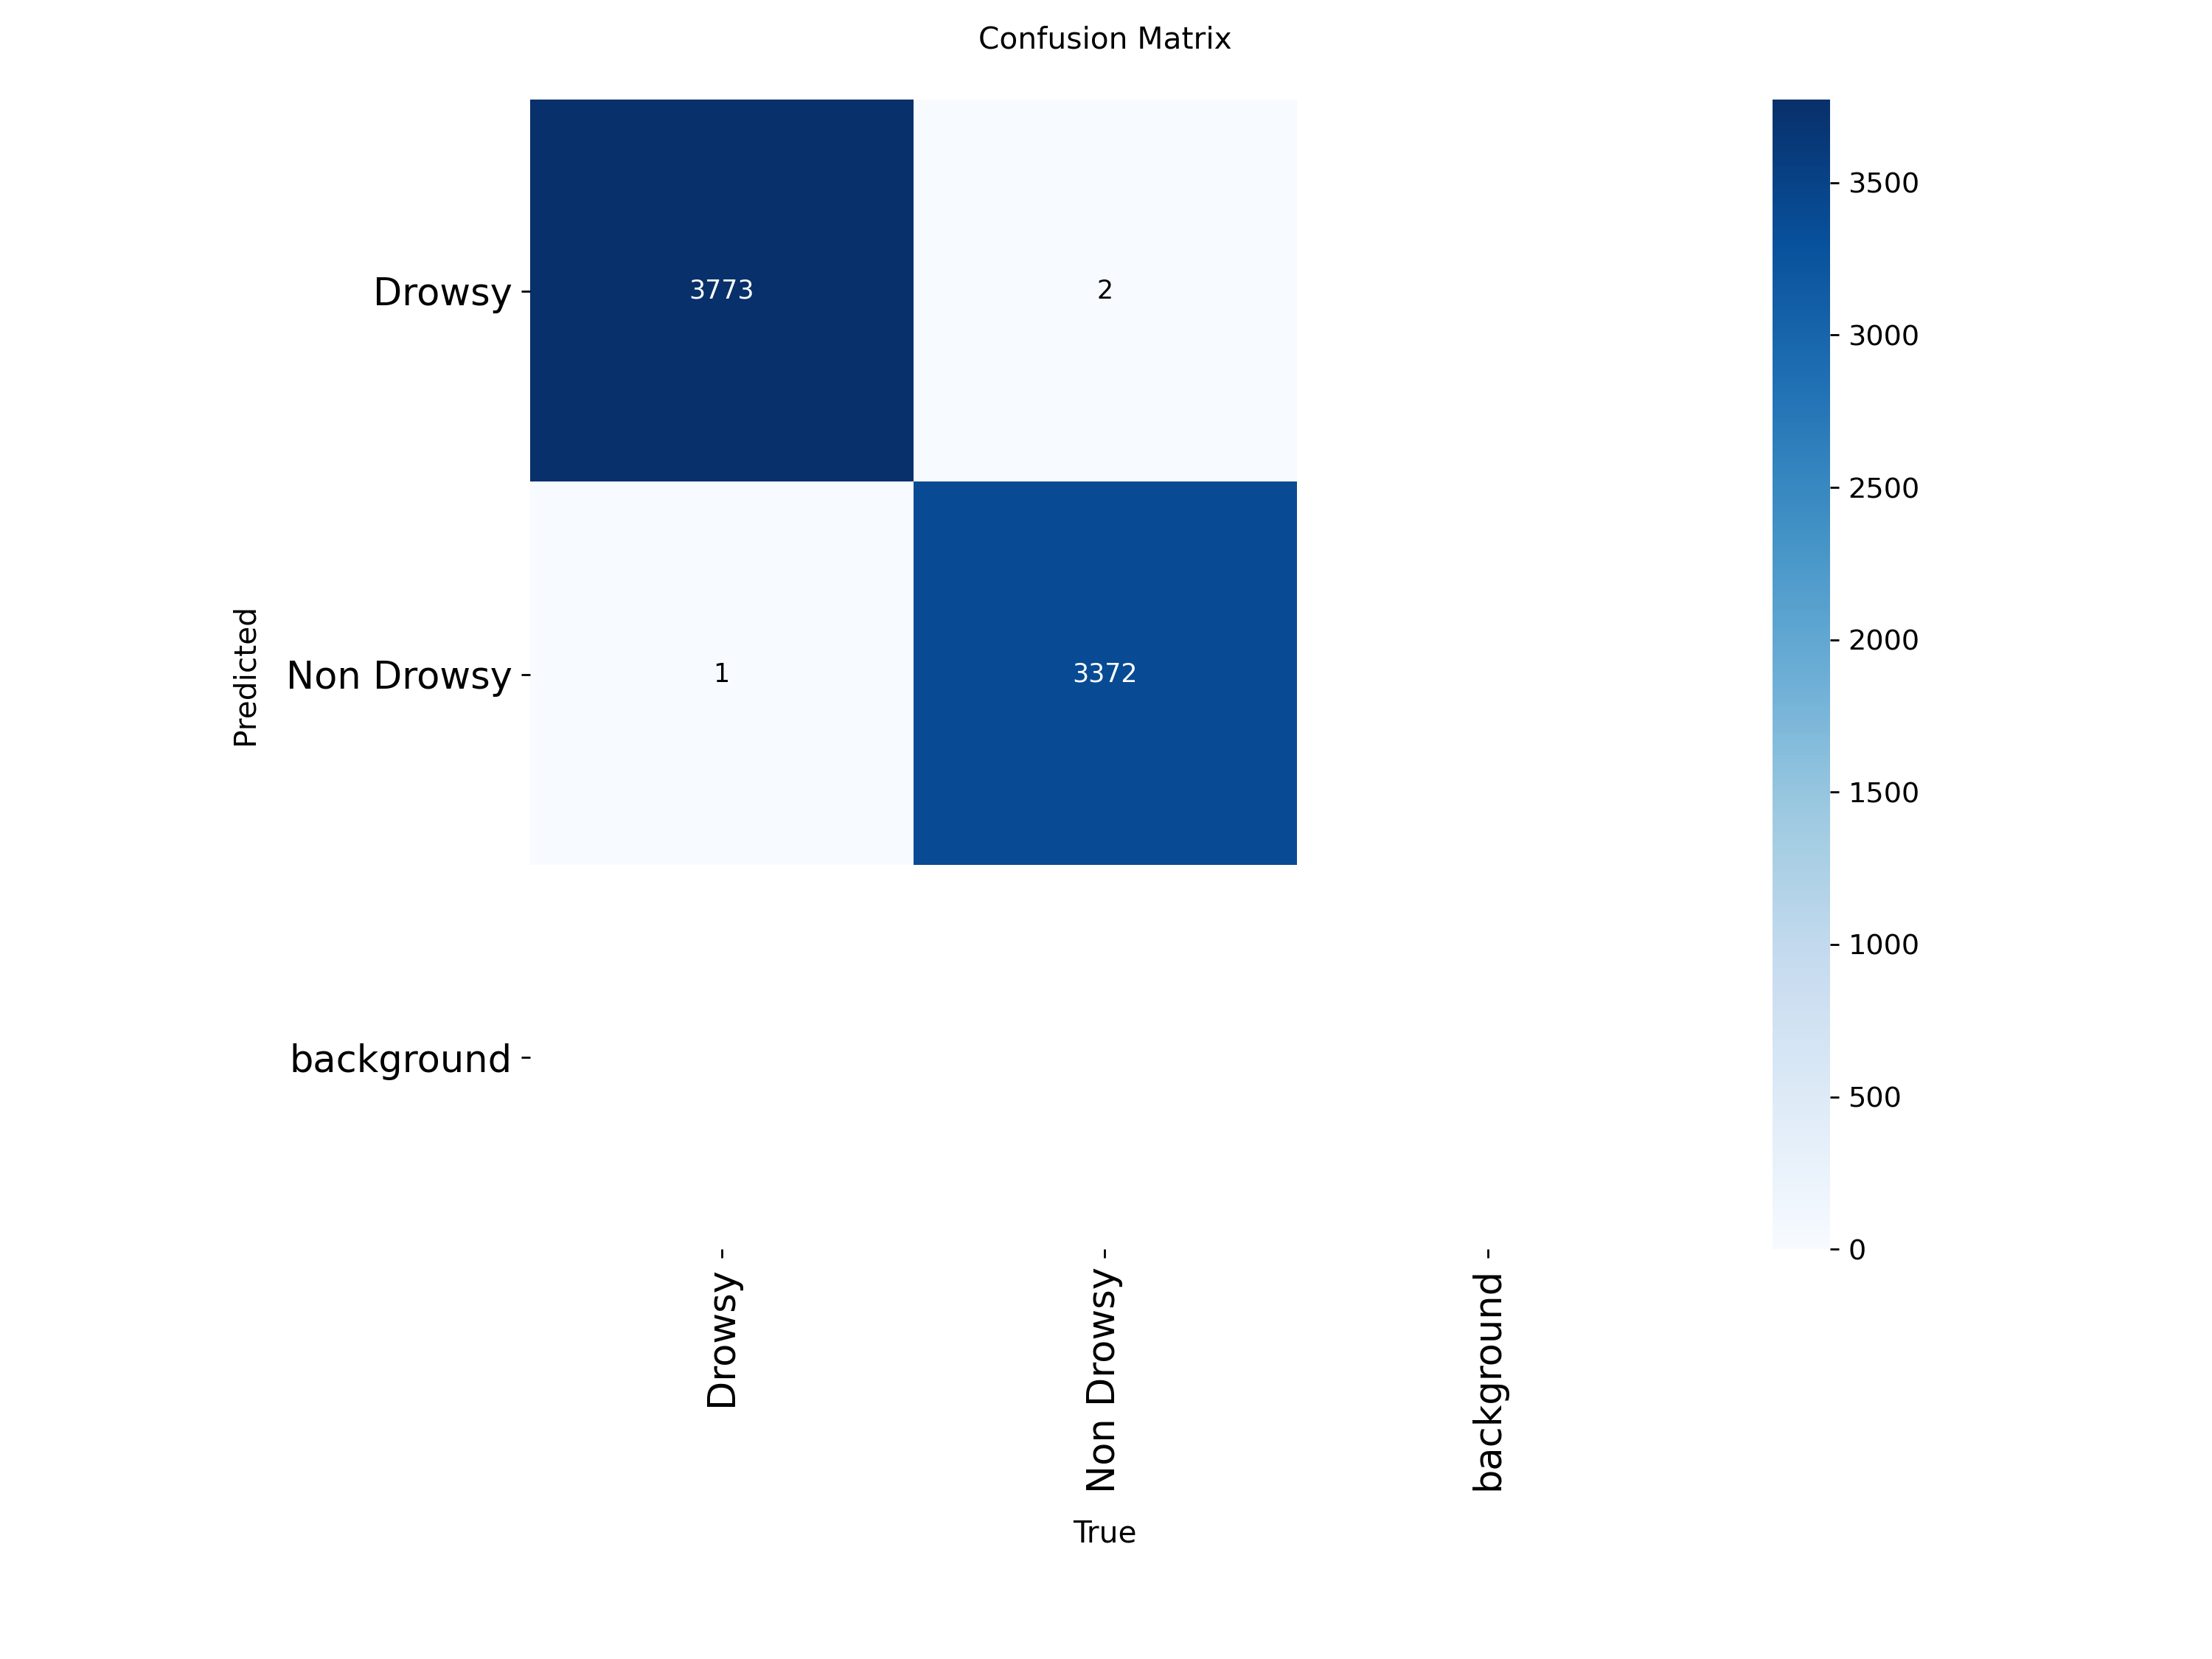

In [13]:
from IPython.display import Image as IPyImage

# Display the image
IPyImage(filename=f"{os.path.join(results.save_dir, 'confusion_matrix.png')}", width=600)

The `results.png` plot shows the loss and accuracy curves for both training and validation sets over epochs. This is the most important visualization for diagnosing training issues.

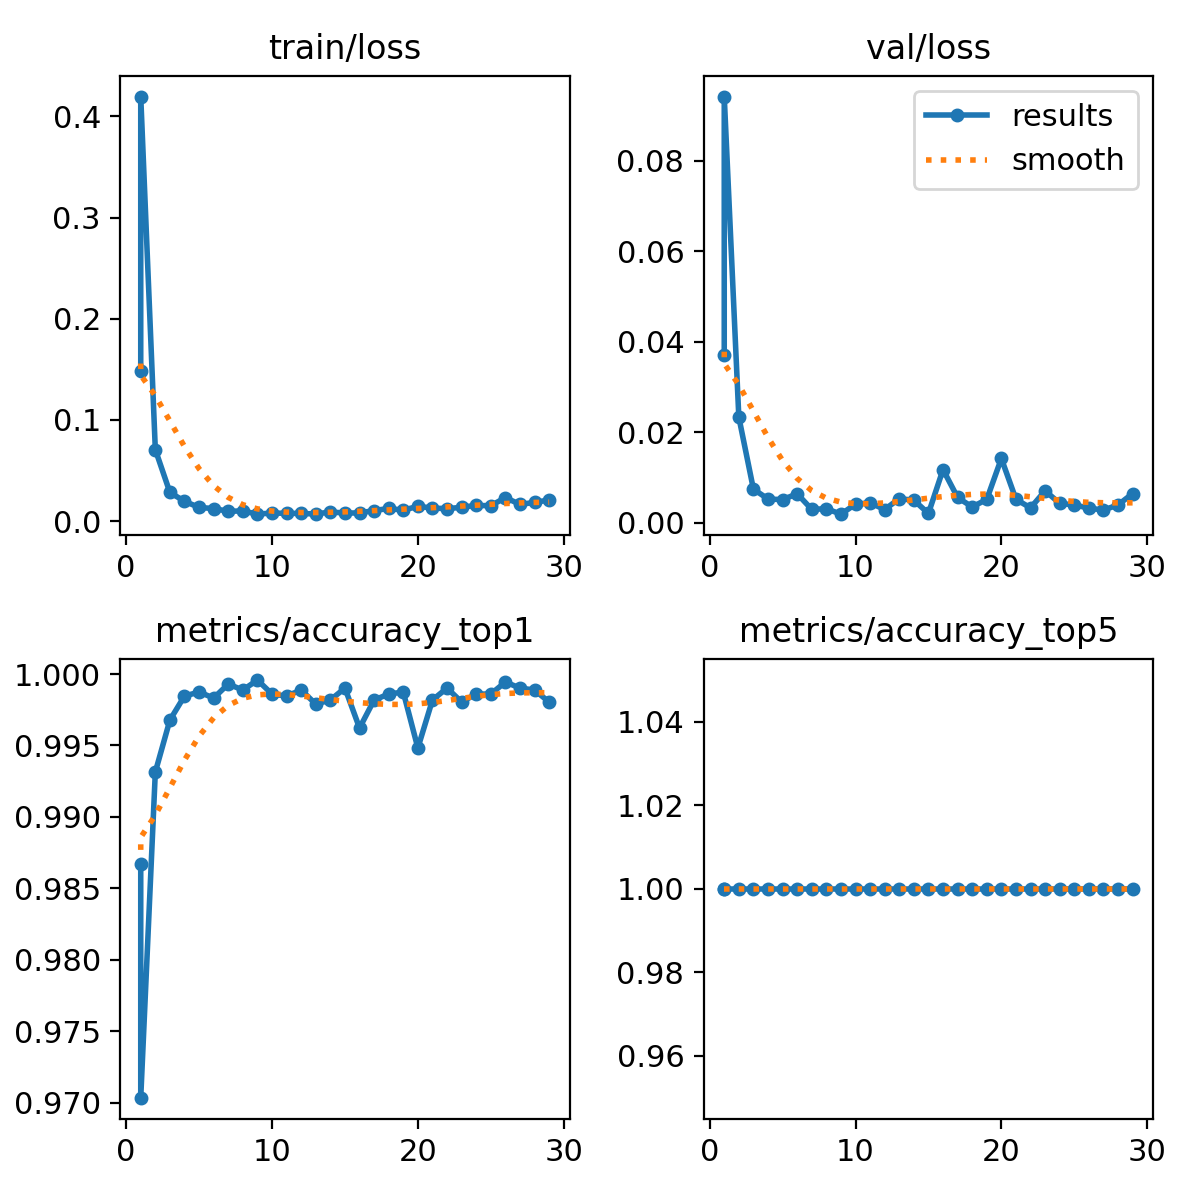

In [14]:
from IPython.display import Image as IPyImage

IPyImage(filename=f"{os.path.join(results.save_dir, 'results.png')}", width=800)

### 6. Model Evaluation on Test Set

We perform an evaluation on the **unseen test set**, this provides the most honest assessment of the model's ability to generalize to new data.

#### Importance of Specialized Metrics

Standard accuracy can be misleading, especially in applications like drowsiness detection where the cost of different errors is not equal.

-   A **False Negative** (classifying a `Drowsy` driver as `Non Drowsy`) is far more dangerous than a **False Positive** (classifying a `Non Drowsy` driver as `Drowsy`).

To capture this, we use these metrics:

-   **APCER (Attack Presentation Classification Error Rate)**: The rate at which `Drowsy` drivers are misclassified as `Non Drowsy`. This is our critical safety metric. **A low APCER is paramount.**

-   **BPCER (Bona Fide Presentation Classification Error Rate)**: The rate at which `Non Drowsy` drivers are misclassified as `Drowsy`. This relates to usability (e.g., false alarms). 

-   **ACER (Average Classification Error Rate)**: The average of APCER and BPCER, giving a single score that balances the two types of errors.

In [16]:
from ultralytics import YOLO
import yaml
import os

# --- 1. Load the Best Model --- 
best_model_path = os.path.join(results.save_dir, 'weights/best.pt')
if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"Best model not found at {best_model_path}. Please ensure training was successful.")

model = YOLO(best_model_path)
print(f"Loaded best model from: {best_model_path}")

# --- 2. Create a data.yaml that satisfies the validator's requirements ---
# The ultralytics validator needs a YAML file with 'train' and 'val' keys.
# We will point the 'val' key to our test directory to evaluate the test set.
train_dir = os.path.join(DATASET_PATH, 'train')
test_dir = os.path.join(DATASET_PATH, 'test')
class_names = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])

data_yaml = {
    'train': train_dir,
    'val': test_dir,
    'names': class_names
}
yaml_file_path = os.path.join(DATASET_PATH, 'test_config.yaml')
with open(yaml_file_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f"Created test configuration at: {yaml_file_path}")
print(f"YAML contents:\n{yaml.dump(data_yaml)}")

# --- 3. Run Validation on the Test Set ---
print("\nRunning evaluation on the test set...")
test_results = model.val(
    data=yaml_file_path, 
    project='drowsiness_evaluation', 
    name='test_set_eval', 
    exist_ok=True,
    split='val' # Explicitly tell it to use the 'val' path from the YAML
)

Loaded best model from: drowsiness_training/yolo_cls_run/weights/best.pt
Created test configuration at: /workspace/dataset/test_config.yaml
YAML contents:
names:
- Drowsy
- Non Drowsy
train: /workspace/dataset/train
val: /workspace/dataset/test


Running evaluation on the test set...
Ultralytics 8.3.160 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA RTX A5000, 24138MiB)
YOLO11x-cls summary (fused): 94 layers, 28,334,978 parameters, 0 gradients, 110.3 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 0.9±0.1 MB/s, size: 1.7 KB)


val: Scanning /workspace/dataset/test... 1483 images, 0 corrupt: 100%|██████████| 1483/1483 [00:00<00:00, 2220.38it/s]


val: New cache created: /workspace/dataset/test.cache


               classes   top1_acc   top5_acc: 100%|██████████| 93/93 [00:02<00:00, 45.53it/s]


                   all      0.998          1
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to drowsiness_evaluation/test_set_eval


#### Evaluate with Specialized Metrics

In [20]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

print("--- Test Set Performance ---")
# The results object contains the top-1 accuracy directly.
accuracy = test_results.top1
print(f"Accuracy: {accuracy:.4f}")

# --- Drowsiness-Specific Metrics ---
print("\n--- Drowsiness Detection Metrics on Test Set ---")

# The confusion matrix is available in the results object.
cm = test_results.confusion_matrix.matrix

# The class names are stored in the model object itself.
class_names = model.names
print(f"Class Names: {class_names}")
print(f"Confusion Matrix:\n{cm}")

drowsy_idx = class_names[0]
nondrowsy_idx = class_names[1]

# Define the integer indices for our classes based on the alphabetical order
# used by the ultralytics trainer.
# class_names[0] would be 'Drowsy', class_names[1] would be 'Non Drowsy'.
drowsy_idx = 0
nondrowsy_idx = 1

# Ensure the confusion matrix has the expected shape before indexing.
if cm.shape[0] < 2 or cm.shape[1] < 2:
    print("\nError: Confusion matrix is smaller than 2x2. Cannot calculate metrics.")
else:
    # APCER (Attack Presentation Classification Error Rate):
    # This is the rate at which 'Drowsy' (the "attack") is misclassified as 'Non Drowsy'.
    # This is a False Negative for the 'Drowsy' class.
    # It's calculated as: (Drowsy samples predicted as Non Drowsy) / (Total actual Drowsy samples)
    drowsy_total = cm[drowsy_idx, :].sum()
    drowsy_misclassified_as_nondrowsy = cm[drowsy_idx, nondrowsy_idx]
    apcer = drowsy_misclassified_as_nondrowsy / drowsy_total if drowsy_total > 0 else 0.0

    # BPCER (Bona Fide Presentation Classification Error Rate):
    # This is the rate at which 'Non Drowsy' (the "bona fide" or normal case) is misclassified as 'Drowsy'.
    # This is a False Positive for the 'Drowsy' class.
    # It's calculated as: (Non Drowsy samples predicted as Drowsy) / (Total actual Non Drowsy samples)
    nondrowsy_total = cm[nondrowsy_idx, :].sum()
    nondrowsy_misclassified_as_drowsy = cm[nondrowsy_idx, drowsy_idx]
    bpcer = nondrowsy_misclassified_as_drowsy / nondrowsy_total if nondrowsy_total > 0 else 0.0

    # ACER: Average of the two error rates.
    acer = (apcer + bpcer) / 2.0

    print(f'\nAPCER (Rate of Drowsy classified as Non Drowsy): {apcer:.4f}')
    print(f'BPCER (Rate of Non Drowsy classified as Drowsy): {bpcer:.4f}')
    print(f'ACER (Average Classification Error Rate): {acer:.4f}')

--- Test Set Performance ---
Accuracy: 0.9980

--- Drowsiness Detection Metrics on Test Set ---
Class Names: {0: 'Drowsy', 1: 'Non Drowsy'}
Confusion Matrix:
[[        754           0           0]
 [          3         726           0]
 [          0           0           0]]

APCER (Rate of Drowsy classified as Non Drowsy): 0.0000
BPCER (Rate of Non Drowsy classified as Drowsy): 0.0041
ACER (Average Classification Error Rate): 0.0021


Visualizations provide an intuitive understanding of model performance.

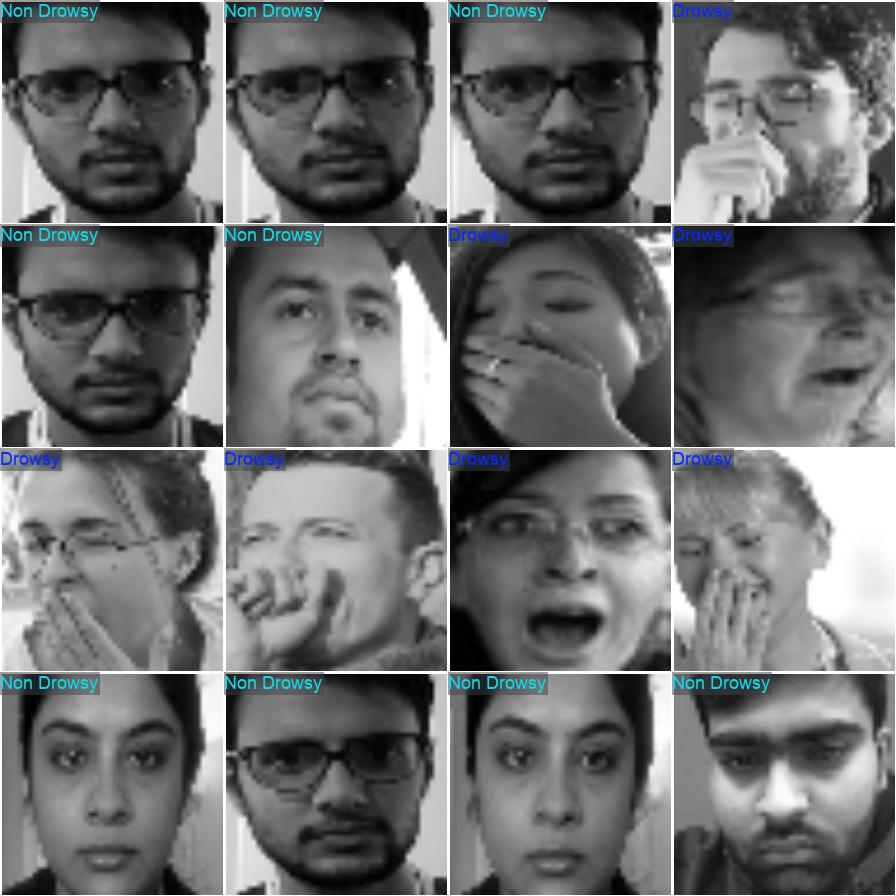

In [22]:
from IPython.display import Image as IPyImage

eval_path = f"{HOME}/drowsiness_evaluation/test_set_eval"

# Display the image
IPyImage(filename=f"{os.path.join(eval_path, 'val_batch0_pred.jpg')}", width=600)

### 7. Model Explainability with Grad-CAM

This section allows us to understand *why* the model makes certain predictions.

**Gradient-weighted Class Activation Mapping (Grad-CAM)** is a technique that produces a heatmap highlighting the regions in an image that were most influential for the model's decision. 

For a drowsiness detector, we expect Grad-CAM to highlight facial features like the eyes, mouth, or head position. This confirms the model is learning relevant patterns and not relying on spurious correlations in the background.

GradCAM produces a heatmap that highlight the regions in the input image that had the most influence on the model's prediction

In [64]:
import os
import random
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from ultralytics.nn.modules import C2f, C3

def find_last_conv_block(yolo_model):
    """Find the last C2f/C3 layer in model backbone."""
    try:
        backbone = yolo_model.model.model
        conv_blocks = [m for m in backbone if isinstance(m, (C2f, C3))]
        if not conv_blocks:
            print("Error: No C2f or C3 layers found.")
            return None
        return conv_blocks[-1]
    except Exception as e:
        print(f"Could not access target layer: {e}")
        return None

def generate_cam(yolo_model, image_path, target_layer, class_index, save_path, imgsz=224):
    """Generate and save Grad-CAM visualization."""
    pytorch_model = yolo_model.model
    pytorch_model.eval()
    for param in pytorch_model.parameters():
        param.requires_grad_(True)

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: Could not read {image_path}")
        return None
    
    # Preprocess image
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    normalized_img = np.float32(cv2.resize(img_rgb, (imgsz, imgsz))) / 255.0
    input_tensor = torch.from_numpy(normalized_img.transpose(2, 0, 1)).unsqueeze(0).to(yolo_model.device)

    # Generate CAM
    with GradCAM(model=pytorch_model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(class_index)])[0, :]
    
    # Get prediction
    with torch.no_grad():
        model_output = pytorch_model(input_tensor)
    logits = model_output[0] if isinstance(model_output, tuple) else model_output
    probs = torch.nn.functional.softmax(logits, dim=-1)
    pred, pred_class_idx = torch.max(probs, dim=-1)
    
    # Create visualization
    visualization = show_cam_on_image(normalized_img, grayscale_cam, use_rgb=True)
    
    # Plot and save
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Grad-CAM for Target Class: '{yolo_model.names[class_index]}'", fontsize=16)
    
    ax1.imshow(normalized_img)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    ax2.imshow(visualization)
    ax2.set_title(f"Prediction: {yolo_model.names[pred_class_idx.item()]}")
    ax2.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close(fig)
    
    return save_path


# Main execution
print("Running Grad-CAM on test samples...")

os.makedirs(VISUALIZATION_PATH, exist_ok=True)

target_layer = find_last_conv_block(model)

# Get class indices
try:
    class_map_inv = {v: k for k, v in model.names.items()}
    drowsy_idx, nondrowsy_idx = class_map_inv['Drowsy'], class_map_inv['Non Drowsy']
except (AttributeError, KeyError):
    print("Using default class indices: Drowsy=0, Non Drowsy=1")
    drowsy_idx, nondrowsy_idx = 0, 1

generated_paths = []

# Process samples from both classes
for class_name, class_idx in [('Drowsy', drowsy_idx), ('Non Drowsy', nondrowsy_idx)]:
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        files = [f for f in os.listdir(class_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        random_files = random.sample(files, min(2, len(files)))  # Randomly select up to 2 files
        for img_file in random_files:
            img_path = os.path.join(class_dir, img_file)
            base_name = os.path.splitext(img_file)[0]
            save_path = os.path.join(VISUALIZATION_PATH, f"grad_cam_{base_name}_{class_name.lower().replace(' ', '')}.png")
            
            result = generate_cam(model, img_path, target_layer, class_idx, save_path)
            if result:
                generated_paths.append(result)

print(f"Generated {len(generated_paths)} CAM images in {os.path.abspath(VISUALIZATION_PATH)}")
print(f"GradCAM images: {generated_paths}")

Running Grad-CAM on test samples...
Generated 4 CAM images in /workspace/visualizations
GradCAM images: ['/workspace/visualizations/grad_cam_yashar_test_622_0223_drowsy.png', '/workspace/visualizations/grad_cam_yashar_test_379.jpg_0_0490_drowsy.png', '/workspace/visualizations/grad_cam_yashar_test_w0075_0662_nondrowsy.png', '/workspace/visualizations/grad_cam_yashar_test_zc0021_0164_nondrowsy.png']


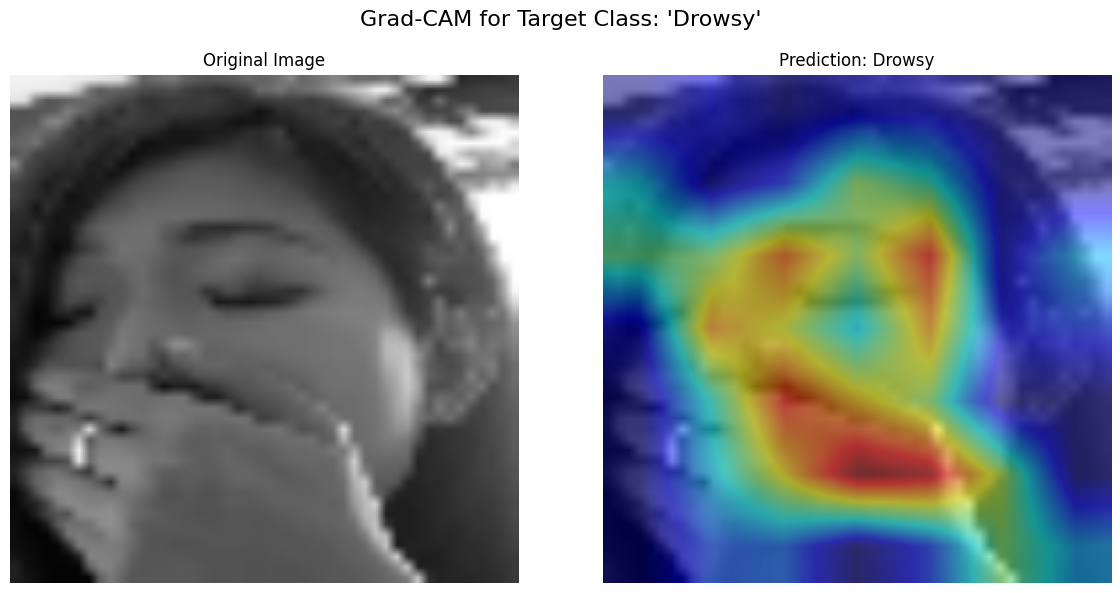

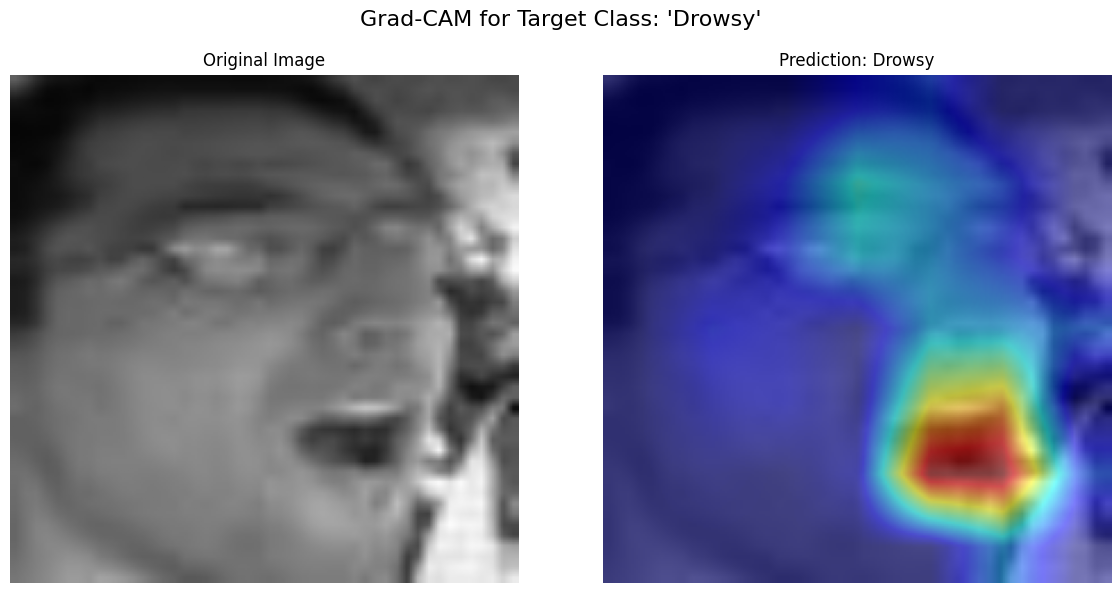

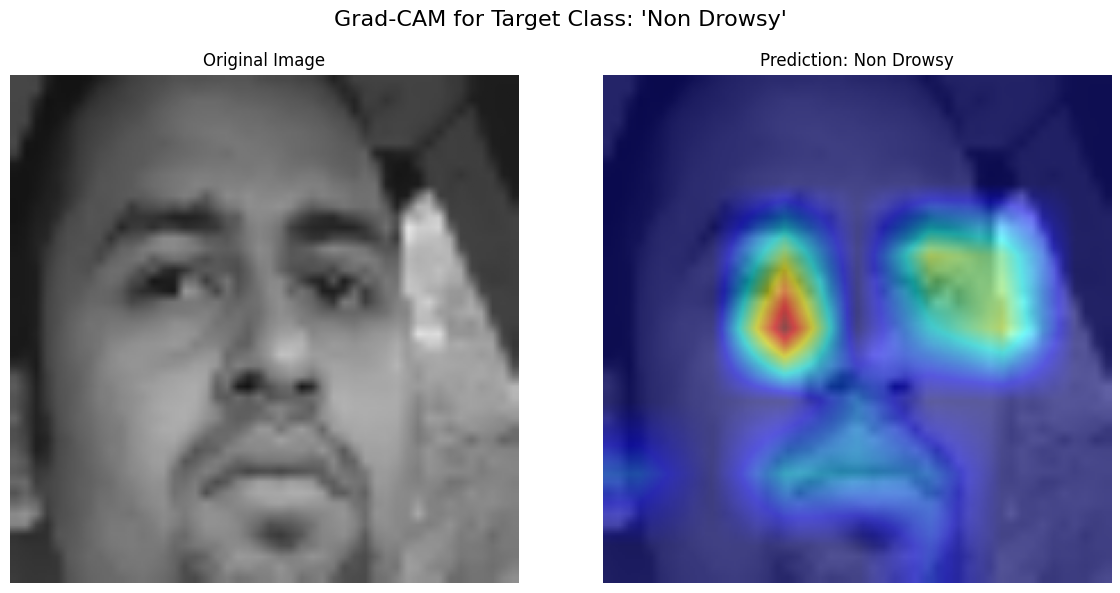

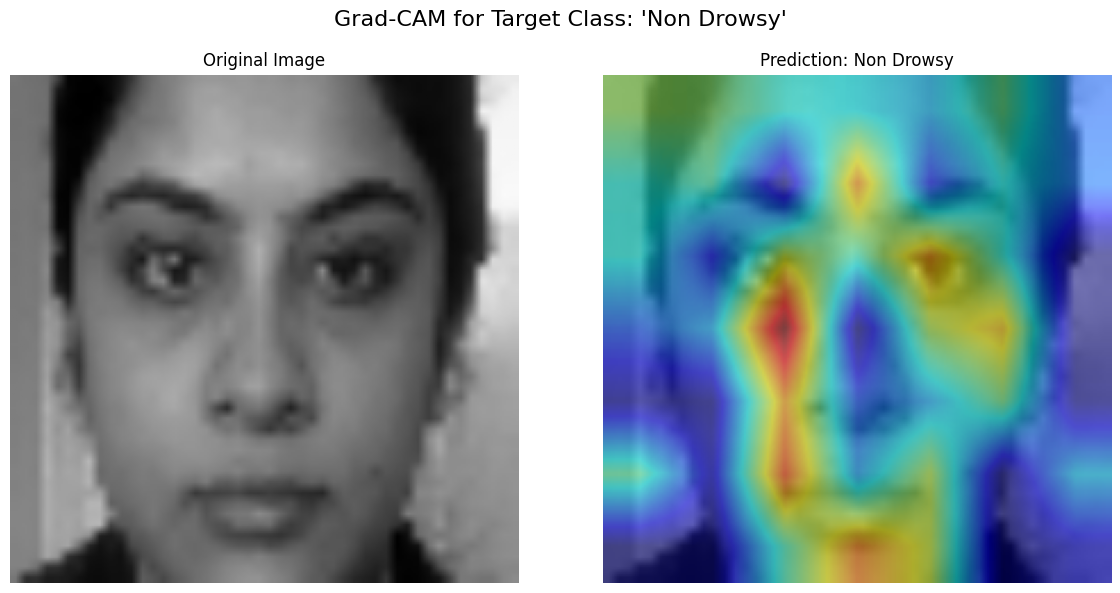

In [65]:
from IPython.display import Image as IPyImage

# Display the grad_cam images
for image_path in generated_paths:
    display(IPyImage(filename=image_path, width=600))

The heat maps demonstrate the model's focus on eye-closure, yawning, and head pose.